<div style="background: linear-gradient(to right, #6a11cb, #2575fc); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
    <h1 style="color: white; margin: 0; font-size: 2.5em; font-weight: 700;">GAICo: Evaluating Structured Outputs</h1>
    <p style="color: #e0e0e0; margin-top: 10px; font-style: italic; font-size: 1.2em; text-align: center;">Planning & Time-Series Examples</p>
</div>
<br>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ai4society/GenAIResultsComparator/blob/main/examples/example-structured_data.ipynb)

This notebook demonstrates how to use **GAICo's** specialized metrics for evaluating structured outputs from Large Language Models (LLMs), specifically in the domains of **automated planning** and **time-series analysis**.

We will cover two main scenarios:

1.  **Planning Sequence Comparison:**

    - We'll evaluate LLM-generated action plans against a reference plan.
    - We will use `PlanningLCS` to check for ordered sequence similarity and `PlanningJaccard` to check for the presence of correct actions, regardless of order.

2.  **Time-Series Data Comparison:**

    - We'll evaluate LLM-generated time-series forecasts against reference data.
    - We will use the updated `TimeSeriesElementDiff` metric, which provides a weighted comparison of both time points (keys) and their corresponding values. We will also show how to customize this weighting.


### Setup for Google Colab

If you are running this notebook in Google Colab, uncomment and run the following cell to install the `gaico` package.

If you are running locally, you can skip this cell if you have already set up your environment according to the project's README.


In [1]:
# !pip install gaico -q

### Environment Setup & Imports

The cell below adjusts `sys.path` to find the gaico module if run from examples directory.

This block is primarily for local execution from the `examples/` folder if gaico is not installed.


In [2]:
import os
import sys

# Adjust sys.path to find the gaico module if run from examples directory
notebook_dir = os.getcwd()  # Get the current working directory of the notebook
# Construct the path to the project root (one level up)
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir))

# Add project root to the system path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added project root to sys.path: {project_root}")

In [3]:
# Import the Experiment class for streamlined comparison
from gaico import Experiment

# Import a specific metric class to show direct instantiation
from gaico.metrics.structured import TimeSeriesElementDiff

---

## Part 1: Planning Sequence Metrics

In this section, we'll evaluate different LLM-generated action plans. An ideal plan should contain the correct actions in the correct order. Some actions might be able to run concurrently, which we represent using `{}`.

- **`PlanningLCS` (Longest Common Subsequence):** This metric is sensitive to the order of actions. A higher score means the generated plan follows the reference plan's sequence more closely.

- **`PlanningJaccard`:** This metric treats the plans as sets of actions and measures their similarity. It is insensitive to order and is useful for checking if all the necessary actions are present, even if they are reordered.


In [4]:
# 1. Define the planning data
# The reference plan includes a set of concurrent actions {action_2a, action_2b}
reference_plan = "action_1, {action_2a, action_2b}, action_3"

llm_plans = {
    "PerfectModel": "action_1, {action_2a, action_2b}, action_3",  # Identical to reference
    "ReorderedModel": "action_3, action_1, {action_2b, action_2a}",  # Correct actions, wrong order
    "IncompleteModel": "action_1, action_3",  # Missing the concurrent actions
    "ExtraActionModel": "action_1, {action_2a, action_2b}, action_4, action_3",  # Has an extra action
}

print("Reference Plan:", reference_plan)
print("\nLLM-Generated Plans:")

for model, plan in llm_plans.items():
    print(f"- {model}: {plan}")

Reference Plan: action_1, {action_2a, action_2b}, action_3

LLM-Generated Plans:
- PerfectModel: action_1, {action_2a, action_2b}, action_3
- ReorderedModel: action_3, action_1, {action_2b, action_2a}
- IncompleteModel: action_1, action_3
- ExtraActionModel: action_1, {action_2a, action_2b}, action_4, action_3


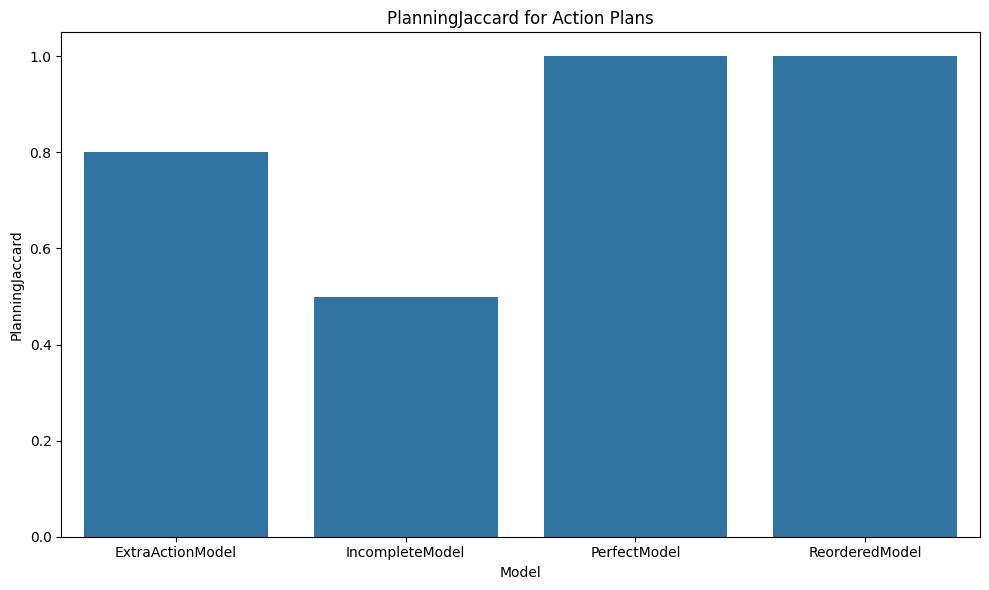

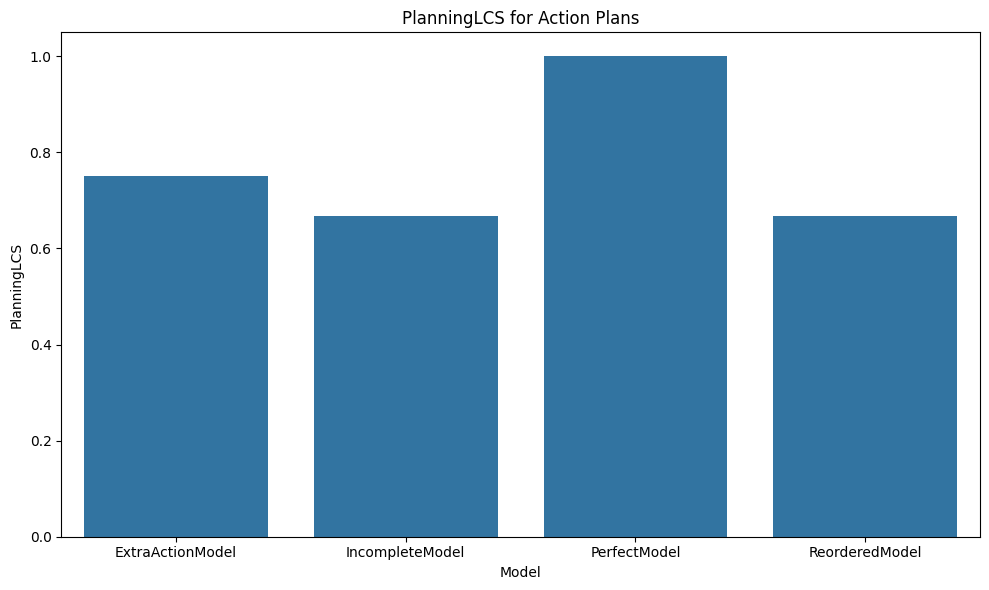


DataFrame of Planning Metric Scores:
         model_name      metric_name     score
0      PerfectModel      PlanningLCS  1.000000
1      PerfectModel  PlanningJaccard  1.000000
2    ReorderedModel      PlanningLCS  0.666667
3    ReorderedModel  PlanningJaccard  1.000000
4   IncompleteModel      PlanningLCS  0.666667
5   IncompleteModel  PlanningJaccard  0.500000
6  ExtraActionModel      PlanningLCS  0.750000
7  ExtraActionModel  PlanningJaccard  0.800000


In [5]:
# 2. Initialize and run the Experiment
planning_exp = Experiment(llm_responses=llm_plans, reference_answer=reference_plan)

# Ensure output directory exists
output_dir_planning = os.path.join("data", "structured_examples")
os.makedirs(output_dir_planning, exist_ok=True)
csv_path_planning = os.path.join(output_dir_planning, "planning_metrics_report.csv")

# 3. Compare using both planning metrics
planning_results_df = planning_exp.compare(
    metrics=["PlanningLCS", "PlanningJaccard"],
    plot=True,
    output_csv_path=csv_path_planning,
    plot_title_suffix="for Action Plans",
)

print("\nDataFrame of Planning Metric Scores:")
print(planning_results_df)

### Analysis of Planning Results

The plots and the DataFrame above reveal the strengths of each metric:

- **PerfectModel**: Scores `1.0` on both metrics, as expected.

- **ReorderedModel**: Scores `1.0` on `PlanningJaccard` because it contains the exact same set of actions as the reference. However, its `PlanningLCS` score is lower because the actions are not in the correct order. This demonstrates how to distinguish between having the right "ingredients" and following the right "recipe".

- **IncompleteModel** and **ExtraActionModel**: Both are penalized by both metrics, as they either miss required actions or include unnecessary ones.


---

## Part 2: Time-Series Data Metrics

Here, we evaluate LLM-generated time-series data. The `TimeSeriesElementDiff` metric is designed to provide a nuanced score by considering:

1.  **Key Matching:** Are the time points (e.g., `t1`, `t2`) correct?

2.  **Value Similarity:** How close are the generated values to the reference values for the matching keys?

By default, a matching key is weighted twice as much as a perfectly matching value, but this is customizable.


In [6]:
# 1. Define the time-series data
reference_ts = "t1: 70, t2: 72, t3: 75"

llm_forecasts = {
    "PerfectModel": "t1: 70, t2: 72, t3: 75",  # Identical
    "GoodValueModel": "t1: 71, t2: 73, t3: 74",  # All keys match, values are close
    "MissingPointModel": "t1: 70, t3: 75",  # Missing the t2 data point
    "WrongKeyModel": "t1: 70, t2: 72, t4: 80",  # Has t4 instead of t3
}

print("Reference Time-Series:", reference_ts)
print("\nLLM-Generated Forecasts:")
for model, forecast in llm_forecasts.items():
    print(f"- {model}: {forecast}")

Reference Time-Series: t1: 70, t2: 72, t3: 75

LLM-Generated Forecasts:
- PerfectModel: t1: 70, t2: 72, t3: 75
- GoodValueModel: t1: 71, t2: 73, t3: 74
- MissingPointModel: t1: 70, t3: 75
- WrongKeyModel: t1: 70, t2: 72, t4: 80


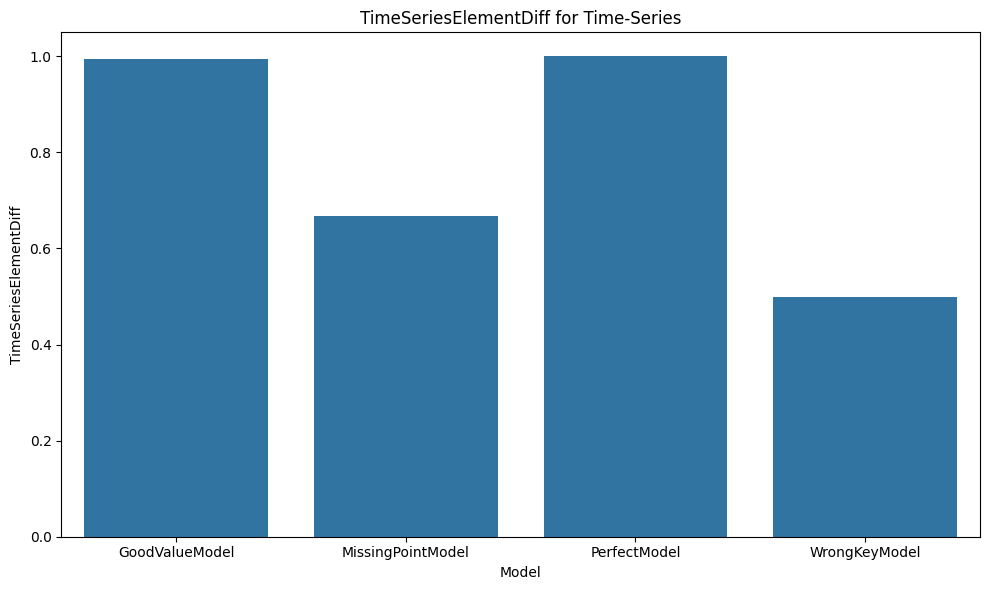

CSV report generated at: data/structured_examples/timeseries_metrics_report.csv

DataFrame of Time-Series Metric Scores (Default Weights):
          model_name            metric_name     score
0       PerfectModel  TimeSeriesElementDiff  1.000000
1     GoodValueModel  TimeSeriesElementDiff  0.995388
2  MissingPointModel  TimeSeriesElementDiff  0.666667
3      WrongKeyModel  TimeSeriesElementDiff  0.500000


In [7]:
# 2. Initialize and run the Experiment with the default metric
ts_exp = Experiment(llm_responses=llm_forecasts, reference_answer=reference_ts)

# Ensure output directory exists
output_dir_ts = os.path.join("data", "structured_examples")
os.makedirs(output_dir_ts, exist_ok=True)
csv_path_ts = os.path.join(output_dir_ts, "timeseries_metrics_report.csv")

# 3. Compare using the TimeSeriesElementDiff metric
ts_results_df = ts_exp.compare(
    metrics=["TimeSeriesElementDiff"],
    plot=True,
    output_csv_path=csv_path_ts,
    plot_title_suffix="for Time-Series",
)

print("\nDataFrame of Time-Series Metric Scores (Default Weights):")
print(ts_results_df)

### Customizing Time-Series Metric Weights

The `Experiment` class uses the default initialization for metrics. To use custom parameters, like changing the `key_to_value_weight_ratio` in `TimeSeriesElementDiff`, you can instantiate the metric class directly.

Let's see how changing the weight affects the score for the `GoodValueModel`. We will compare the default ratio (2:1) with a much higher ratio (10:1), which should place more importance on matching keys and less on value accuracy.


In [8]:
# Instantiate metrics with different weights
ts_metric_default_weight = TimeSeriesElementDiff()  # Default key_to_value_weight_ratio = 2.0
ts_metric_high_key_weight = TimeSeriesElementDiff(key_to_value_weight_ratio=10.0)

# The data for the model we are testing
generated_ts = llm_forecasts["GoodValueModel"]

# Calculate scores with both metric instances
score_default = ts_metric_default_weight.calculate(generated_ts, reference_ts)
score_high_weight = ts_metric_high_key_weight.calculate(generated_ts, reference_ts)

print(f"Score for 'GoodValueModel' with default key:value weight (2:1): {score_default:.4f}")
print(f"Score for 'GoodValueModel' with high key:value weight (10:1):   {score_high_weight:.4f}")

Score for 'GoodValueModel' with default key:value weight (2:1): 0.9954
Score for 'GoodValueModel' with high key:value weight (10:1):   0.9987


As you can see, when we increase the weight of matching keys relative to values, the score for `GoodValueModel` increases. This is because the penalty for its slightly inaccurate values becomes less significant compared to the reward for correctly identifying all the time points. This customizability allows you to tailor the evaluation to what matters most for your specific application.

### Conclusion

This notebook has demonstrated how to leverage GAICo's specialized metrics for structured data. By choosing the right metric—or even customizing its parameters—you can gain deeper, more meaningful insights into the performance of LLMs on tasks that go beyond simple text generation.
